<a href="https://colab.research.google.com/github/anht-nguyen/be521_final/blob/master/v2_BE521_final_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Set up the notebook environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.io import loadmat, savemat
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.signal import butter, lfilter, filtfilt, ellip, resample
from scipy.interpolate import CubicSpline

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime

**For final_project part 1, we removed channel 55 in subject 1, and we removed channels 21 and 38 from subject 2**

## Data preparation

In [ ]:
class data_preparation:
    # def __init__(self):
    #   pass

  def split_data(self, fil_training_data):
    keylist = list(fil_training_data.keys())
    if np.size(keylist) > 2:
      keylist = keylist[3:]

    # print(keylist)
    train_data = {keylist[0]:[], keylist[1]:[]}
    test_data = {keylist[0]:[], keylist[1]:[]}
    for key in keylist:
        for i in range(3):
          m,n = np.shape(fil_training_data[key][i])
          train_data[key].append(fil_training_data[key][i][:int(m/3*2),:])
          test_data[key].append(fil_training_data[key][i][int(m/3*2):,:])
    return train_data, test_data

  def filter_rawdic(self, raw_data):
    keylist = list(raw_data.keys())[3:]
    fil_data = {}
    for key in keylist:
        fil_data[key] = []
        for i in range(3):
            fil_data[key].append(self.filter_data(raw_data[key][i][0]))
    return fil_data

  def filter_data(self, raw_eeg, fs=1000):
    """
    Write a filter function to clean underlying data.
    Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
    Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
    distorting the underlying data!

    Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
    Output: 
    clean_data (samples x channels): the filtered signal
    """

    m,n = np.shape(raw_eeg)

    # Band-pass filter:  
    lowcut = 0.5
    highcut = 200

    b, a = butter(N = 5, Wn = [lowcut, highcut], fs = fs, btype='bandpass')
    y1 = np.stack([filtfilt(b,a, raw_eeg[:,i]) for i in range(n)]) 
    clean_data = y1.T

    # Bandstop filter:   
    bsfreq = np.array([[59, 61], [119, 121], [179, 181]])
    for k in range(np.shape(bsfreq)[0]):
        b1, a1 = butter(N = 4, Wn = bsfreq[k,:], btype = 'bandstop', fs = fs)  
        y2 = np.stack([ filtfilt(b1,a1, clean_data[:,i]) for i in range(n) ])
        clean_data = y2.T
    return clean_data

### Dimensionality Reduction

In [ ]:
class PCA_feats:
  def pca_visualize(self, num_prin, feat_data):
    """
    Input: 
      num_prin: number of principles
      feat_data: (N_sample x N_feature) feature matrix of 1 finger and 1 subject
    Output: the threshhold of num_prin that could produce cummunlative percentage explained > 80%
    Note: might want to draw horizontal and vertical lines to show the threshholds (for report)
    """
    cum_percent_variance = np.array([])
    for i in range(1,num_prin):
      pca_i = PCA(n_components = i)
      data_pcai = pca_i.fit_transform(feat_data) # PCA-reduced
      cum_percent_variance = np.append(cum_percent_variance, np.sum(pca_i.explained_variance_ratio_))


    plt.figure(figsize = (16,8))
    color = 'tab:blue'
    plt.ylabel('Principal component', color=color)  
    plt.bar(np.arange(1,num_prin,1), pca_i.explained_variance_, color=color)
    plt.tick_params(axis='y', labelcolor=color)

    plt.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    plt.xlabel('time (s)')
    plt.ylabel('Cumulative percent variance explained [%]', color=color)
    plt.plot(np.arange(1,num_prin,1), cum_percent_variance*100, color=color)
    plt.tick_params(axis='y', labelcolor=color)

    plt.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    thresh_percent = 80
    thresh_pca = np.where(cum_percent_variance*100 > thresh_percent)[0][0]

    return thresh_pca


  def pca_feats(self, feats, num_prin):
    """
    feats: feature data imported from mat file
    new_feats: pca-reduced feature data with the same shape with input feature data
    """
    new_feats = feats.copy()
    print(num_prin)
    pca = PCA(n_components = num_prin)
    for subj in range(3):
      new_feats[subj][0] = pca.fit_transform(feats[subj][0]) 
    return new_feats


In [ ]:
# # test filter function
# fil_training_0 = filter_data(raw_training_data['train_ecog'][0][0]) # proj_data_filtered
# plt.figure(figsize=(15,6))
# plt.subplot(121)
# freq_domain(raw_training_data['train_ecog'][0][0][:,0], True)
# plt.title('Freq-domain raw data')
# plt.xlabel('Freq')

# plt.subplot(122)
# freq_domain(fil_training_0[:,0], True)
# plt.title('Freq_domain filtered data')
# plt.xlabel('Freq')
# plt.show()

## Calculating features and store them to mat files

In [ ]:
class feats_extraction:
  def freq_domain(self, X, doplot = False):
    N = len(X)
    n = np.arange(N)
    T = N/200
    freq = n/T 
    sd = np.fft.fft(X)
    if doplot:
        plt.plot(freq, np.abs(sd))
        # plt.xlim([0, 500])
    return [freq, np.abs(sd)]

  def NumWins(self, x, fs, winLen, winDisp):
    if np.size(np.shape(x)) == 2:
        xLen,_ = np.shape(x)
    else:
        xLen = np.size(x)
    NumWindows = int((xLen - winLen*fs)/(winDisp*fs))+1 # updated from "round((xLen - winLen*fs)/(winDisp*fs))"
    return NumWindows

  def bandpower(self, data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    Ref: https://raphaelvallat.com/bandpower.html
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf) #, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

  def get_features(self, filtered_window, fs, isTrain, mean_train, std_train):
    """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!

    Input: 
      filtered_window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate
      isTrain = True when it is training data
      mean, std_train: use for feats_test when isTrain = False
    Output:
      features (channels x num_features): the normalized features calculated on each channel for the window
      (if iTrain = True -> feats_train): return mean and std of feats_train normalization 
    """
    
    m,n = np.shape(filtered_window)
    # Average time-domain voltage 
    MeanVol = np.stack([ np.mean(filtered_window[:,i]) for i in range(n) ])

    # Average freq-domain magnitude in several freq bands (kubanek et al, 2009)
    freqbands = np.array([[5,15], [20,25], [75, 115], [125, 160], [160, 175]]) *m/200;
    MeanAmp0 = np.stack([ np.mean(self.freq_domain(filtered_window[:,i])[1][int(freqbands[0,0]):int(freqbands[0,1])] ) 
      for i in range(n) ])

    MeanAmp1 = np.stack([ np.mean(self.freq_domain(filtered_window[:,i])[1][int(freqbands[1,0]):int(freqbands[1,1])] ) 
      for i in range(n) ])

    MeanAmp2 = np.stack([ np.mean(self.freq_domain(filtered_window[:,i])[1][int(freqbands[2,0]):int(freqbands[2,1])] ) 
      for i in range(n) ]) 

    MeanAmp3 = np.stack([ np.mean(self.freq_domain(filtered_window[:,i])[1][int(freqbands[3,0]):int(freqbands[3,1])] ) 
      for i in range(n) ]) 
    
    MeanAmp4 = np.stack([ np.mean(self.freq_domain(filtered_window[:,i])[1][int(freqbands[4,0]):int(freqbands[4,1])] ) 
      for i in range(n) ])

    # Bandpower of freq band [0-20 Hz] (warland et al, 1997)
    # BP = np.stack([ bandpower(filtered_window[:,i], sf = 1000, band =[0.5, 20]) for i in range(n) ]) 

    feats =  np.array([MeanVol, MeanAmp0, MeanAmp1, MeanAmp2, MeanAmp3, MeanAmp4]).T

    return feats



  def get_windowed_feats(self, raw_ecog, fs, window_length, window_overlap, isTrain, mean_train, std_train):
    """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap
    Output: 
      all_feats (num_windows x (channels * features)): the features for each channel for each time window
        note that this is a 2D array. 
    """
    
    DP = data_preparation() 
    
    window_disp = window_length-window_overlap
    N = self.NumWins(raw_ecog, fs = fs, winLen = window_length, winDisp = window_disp)

    fil_ecog = DP.filter_data(raw_ecog, fs)

    all_feats = np.array([])
    all_feats = np.stack([ self.get_features(fil_ecog[int(i*window_disp*fs):int(i*window_disp*fs+ window_length*fs),:], fs, isTrain, mean_train, std_train).T.reshape(-1) 
    for i in range(N) ])
    _, vf = np.shape(all_feats) # vf = channels * features 
    if isTrain:
      mean_train = np.mean(all_feats, axis = 0)
      std_train = np.std(all_feats, axis = 0)

    all_feats_norm = np.stack([ (all_feats[:,k] - mean_train[k])/std_train[k]  for k in range(vf) ]).T 
    print('Done feats')

    return all_feats_norm, mean_train, std_train 

    


  def store_split_feats_mat(self, train_fil, test_fil, fs, window_length, window_overlap, dir):
    """
    Export feats_train and feats_test
    """
    #feats_train export       
    obj = np.zeros((3,1), dtype=object)
    mean_train = np.zeros((3,1), dtype=object)
    std_train = np.zeros((3,1), dtype=object)
    for k in range(3): #3
      obj[k][0], mean_train[k][0], std_train[k][0] = self.get_windowed_feats(train_fil['train_ecog'][k], fs, window_length, window_overlap, True, range(500), range(500))
    path = dir + "/" + "feats_train"+ ".mat"
    print(path)
    savemat(path, {"feats_train": obj})

    #feats_test export  
    obj1 = np.zeros((3,1), dtype=object)
    for k in range(3): #3
      obj1[k][0], _, _ = self.get_windowed_feats(train_fil['train_ecog'][k], fs, window_length, window_overlap, False, mean_train[k][0], std_train[k][0])
    path1 = dir + "/" + "feats_test"+ ".mat"
    print(path1)
    savemat(path1, {"feats_test": obj1})


  def store_whole_feats_mat(self, raw_training_data, leaderboard_data, fs, window_length, window_overlap, dir):

    #feats_training_data export       
    obj = np.zeros((3,1), dtype=object)
    mean_train = np.zeros((3,1), dtype=object)
    std_train = np.zeros((3,1), dtype=object)
    for k in range(3): #3
      obj[k][0], mean_train[k][0], std_train[k][0] = self.get_windowed_feats(raw_training_data['train_ecog'][k][0], fs, window_length, window_overlap, True, range(500), range(500))
    path = dir + "/" + "feats_training_data"+ ".mat"
    print(path)
    savemat(path, {"feats_training_data": obj})

    #feats_leaderboard export  
    obj1 = np.zeros((3,1), dtype=object)
    for k in range(3): #3
      obj1[k][0], _, _ = self.get_windowed_feats(leaderboard_data['leaderboard_ecog'][k][0], fs, window_length, window_overlap, False, mean_train[k][0], std_train[k][0])
    path1 = dir + "/" + "feats_leaderboard"+ ".mat"
    print(path1)
    savemat(path1, {"feats_leaderboard": obj1})


train SVR model, make predictions on testing set and do post-processing. if predictions are better, then R matrix is wack. if prediction are similar, look into feature extraction.

## Optimal Linear Decoder
Linear filter using R matrix (Warland et al., 1997)

In [ ]:
class optimal_linear_decoder:
  def create_R_matrix(self,features, N_wind):
    """ 
    Write a function to calculate the R matrix
    Input:
    features (samples (number of windows in the signal) x channels x features): 
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

    Output:
    R (samples x (N_wind*channels*features))
    """
    M,vf = np.shape(features)
    features_new = np.append(features[:N_wind-1, :].copy(), features, axis=0)

    R = np.stack([ (features_new[i:i+N_wind, :]).reshape(-1) for i in range(M) ])
    R = np.append(np.ones([M,1]), R, axis = 1)
    return R

  def create_weighted_R_matrix(self, features, N_wind, weights):
    """ 
    Write a function to calculate the weighted R matrix
    Input:
    features (samples (number of windows in the signal) x (channels x features)): 
      the features you calculated using get_windowed_feats
    N_wind: (integer) number of windows to use in the R matrix
    weights: (an array of 1 x channels) weight array for each subject and each finger
    Output:
    R (samples x (N_wind*channels*features))
    """
    # print('weights', weights)
    M,vf = np.shape(features)
    # print(np.shape(features))
    N_channels = int(vf/6)
    weighted_features = np.zeros(np.shape(features))
    for f in range(6):
      for channel in range(N_channels):
        weighted_features[:, int(channel + N_channels*f)] = features[:, int(channel + N_channels*f)] * weights[0][channel]
    # print(np.shape(weighted_features))

    features_new = np.append(weighted_features[:N_wind-1, :].copy(), weighted_features, axis=0) #padding the beginning of the feature matrix

    R = np.stack([ (features_new[i:i+N_wind, :]).reshape(-1) for i in range(M) ])
    R = np.append(np.ones([M,1]), R, axis = 1)
    return R
  

  def optimal_linear_decoder(self,N_wind, train_fil, len_test, feats_train, feats_test, weights, window_length, window_overlap, fs=1000):
    """
    Refer to Warland97 and Final Project Part 1, Apply decoding for each fingers. 
    Used to run cross validation on "train_data" to determine the optimal N_wind for best correlation
    Input:
    train_fil: filtered train data (dictionary)
    len_test: number of samples in test_fil
    feats_train, feats_test: array of feature imported from features files 
      (e.g., feats_train = loadmat('<path_to_file>')['feats_train'] )
    
    Output: (3xlen_testx5) prediction for test data
    """
    PP = post_processing()
    predict_dg = []
    # len_test = len(test_fil['train_dg'][0])
    xs = np.arange(0, len_test/fs,1/fs)
    Y_hat = []
    for k in range(3): #3
      print('subj', k)
      #downsampling
      M_train,_ = np.shape(feats_train[k][0])
      Y_train = resample(train_fil['train_dg'][k], M_train)

      for finger in range(5):
        print('finger', finger)
        # weighted R matrices
        R_train = self.create_weighted_R_matrix(feats_train[k][0], N_wind, weights[k,finger])
        R_test = self.create_weighted_R_matrix(feats_test[k][0], N_wind, weights[k,finger])

        f = np.matmul(np.linalg.pinv(np.matmul(R_train.T, R_train)), np.matmul(R_train.T, Y_train[:,finger]))
        Y_hat.append(np.matmul(R_test, f).T)
    print('done matmul')
    print('shape Y_hat', len(Y_hat[0]))
    # Upsampling and reshaping
    predict_dg = PP.upsampling_data( Y_hat, len_test)
    
    # predict_dg = []
    # Y_hat[0] = np.pad(Y_hat[0], (1, 1), 'constant', constant_values=(0,0))
    # print('shape Y_hat', np.shape(Y_hat[0]))
    # xs = np.linspace(0,len(Y_hat[0]), len_test)
    # x = np.arange(0, len(Y_hat[0]), 1)
    # cs = CubicSpline(x, Y_hat[0], bc_type='natural')
    # predict_dg.append(np.array(cs(xs)).T)

    # print('shape predict', np.shape(predict_dg[0]))

    # plt.figure(figsize = (10,5))
    # plt.plot(Y_hat[0])
    # # plt.xlim(0,10)
    # plt.figure(figsize = (10,5))
    # plt.plot(predict[0])
    # # plt.xlim(0, 10000)
    
    # Zeroclamping and smoothing
    predict_dg1 = predict_dg.copy()
    for k in range(3):
      for finger in range(5):
        predict_dg1[k][:,finger] = PP.maf_smoothing(predict_dg[k][:,finger],5000) 

    # plt.figure(figsize = (10,5))
    # plt.plot(predict_dg[0])

    # plt.figure(figsize = (10,5))
    # plt.plot(predict_dg1[0])

    return predict_dg1


  def cor_test_OLD(self,test_fil, predict_dg):
    """
    Compute the correlation between prediction from OLD and recorded flexion data (test_fil['train_dg']) 
    Input: 
      test_fil: filtered test_data (dictionary) 
      predict_dg: (3xlen_testx5) prediction for test data
    Output:
    cor: (3 subjects x 5 fingers) correlation matrix
    np.mean(cor): the average correlation of all subjects and fingers
    """
    from scipy.stats import pearsonr
    cor=[]
    for subj in range(3):
      cor.append([(pearsonr(predict_dg[subj][:,i], test_fil['train_dg'][subj][:,i]))[0] for i in range(5)])
    return np.mean(cor)#, cor
    


  def OLD_cross_val_N_wind(self,N_wind, data_fil, feats_data, weights, window_length, window_overlap, fs=1000):
    """
    Run cross validation for linear decoder (10-folds of "train_data") to determine the optimal value of N_wind that produce highest correlation
    Input: 
    data_fil: filtered data (dictionary)
    feats_data: features matrix of the data
    N_wind: an array of values of N_wind
    Output: 
      list of mean correlations
      values of N_wind inducing max correlations
    """
    from sklearn.model_selection import KFold
    k=10
    # create fold indices for features matrix
    kf = KFold(n_splits = k)
    split = kf.split(feats_data[0][0])
    index_store = []
    for train_index, test_index in split:
      index_store.append([train_index,test_index])
    # print('index',index_store)
    # create fold indices for data dictionary
    split_data = KFold(n_splits = k).split(data_fil['train_dg'][0])
    index_data_store = []
    for train_data_index, test_data_index in split_data:
      index_data_store.append([train_data_index,test_data_index])

    num_folds = 10
    mean_cor=[] 
    mean_cor1 = []
    for n in N_wind:
      print('n',n)
      for i in range(num_folds):
        print('i',i)
        train_fil = {'train_dg':[]}
        test_fil = {'train_dg':[]}
        feats_train = [[],[],[]]
        feats_test = [[],[],[]]
        for subj in range(3):
          print('subj', subj)
          feats_train[subj].append(np.array(feats_data[subj][0][index_store[i][0], :]))
          # print(np.shape(feats_data[subj][0]))
          feats_test[subj].append( np.array(feats_data[subj][0][index_store[i][1], :]))
          
          train_fil['train_dg'].append(data_fil['train_dg'][subj][index_data_store[i][0],:])
          test_fil['train_dg'].append(data_fil['train_dg'][subj][index_data_store[i][1],:])
        # print('shape', feats_train[2][0])
        # print('shape', np.shape(feats_train))

        len_test = len(test_fil['train_dg'][0])
        predict_dg = self.optimal_linear_decoder(n, train_fil, len_test, feats_train, feats_test, weights, window_length, window_overlap, fs=1000)
        # print(np.shape(predict_dg))
        # print(np.shape(test_fil['train_dg']))

        # mean correlation for all fingers and all subjects
        mean_cor.append(self.cor_test_OLD(test_fil, predict_dg))
      
      # average correlation of 10 folds 
      mean_cor1 = np.mean(mean_cor)
      print(mean_cor1)
    return mean_cor1 #, predict_dg, test_fil



  



  def OLD_leaderboard(self, N_wind, fil_training_data, len_leaderboard, feats_training_data, feats_leaderboard, weights, window_length, window_overlap, fs, dir1):
    """
    This function is used when the optimal N_wind is determined after cross-validation. 
    Used for leaderboard_data and raw_training_data when producing final submission data.
    Input: 
    len_leaderboard: number of samples in leaderboard_data
    Output:
    Export submission mat file
    """
    PP = post_processing()

    predict_dg = self.optimal_linear_decoder(N_wind, fil_training_data, len_leaderboard, feats_training_data, feats_leaderboard, weights, window_length, window_overlap, fs=1000)

    PP.export_submission(dir1, predict_dg)
    return predict_dg


## Post-processing

In [ ]:
class post_processing:
  """
  Post processing step: Upsampling => Zero clamping => Moving average filter 
  """

  def upsampling_data(self, Y_hat, len_test): 
    """
    Upscaling and reshaping data 
    Input: 
      Y_hat: 15 elements, each lement is an output of linear filter for each finger
      len_test: 
    Output: (3xlen_testx5) predict_dg
    """
    predict = []
    
    for k in range(3):
      for finger in range(5):
        Y_hat_signal = np.pad(Y_hat[5*k+finger], (1, 1), 'constant', constant_values=(0,0))
        x = np.arange(0, len(Y_hat_signal), 1)
        xs = np.linspace(0,len(Y_hat_signal), len_test)
        cs = CubicSpline(x, Y_hat_signal, bc_type = 'natural')
        predict.append(np.array(cs(xs)).T)
    # Contruct predict_dg output
    predict1 = np.reshape(predict, (3,5, len_test))
    predict_dg = []
    for i in range(3):
      predict_dg.append(np.array(predict1[i]).T)
    return predict_dg


  def zero_clamping(self, data):
    """
    Zero-clamping: negative values of the prediction trace were set to zero, such that it would resemble the rest period baseline signal in the data-glove trace (paraphrase this description if used in report)
    Input: (3xlen_testx5) upsampled prediction data
    """
    import torch
    tensor=torch.tensor(data)
    out = torch.clamp(tensor, min = 0,max = max(tensor))
    return out


  def maf_smoothing(self, data,win_siz):
    """
    Moving Average Filter: reducing random noise while retaining a sharp step response
    data: signal to be  smoothed
    win_siz: number of data points to inlude in window
    """

    #define window size
    window_size = win_siz

    # padding the edge with zeros
    data = np.pad(data, (window_size-1,0), mode='constant', constant_values=0)

    # Convert array of integers to pandas series
    numbers_series = pd.Series(data)

    # Get the window of series of observations of specified window size
    windows = numbers_series.rolling(window_size)

    # Create a series of moving averages of each window
    moving_averages = windows.mean()

    # Convert pandas series to array
    moving_averages_arr = np.array(moving_averages)

    # Remove null entries from the list
    final_arr = moving_averages[window_size - 1:]
    
    return final_arr

  def visualization(self,predict_dg, dg_data):
    """
    visualize data glove and prediction data trace
    """ 
    plt.figure(figsize=(30,10))
    for subj in range(3):
      for f in range(5):
        plt.subplot(3,5,5*subj+f+1)
        plt.plot(dg_data[subj][:,f], color='orange')
        plt.plot(predict_dg[subj][:,f] /np.max(predict_dg[subj][:,f]) * np.max(dg_data[subj][:,f]), 'b')
        
  def export_submission(self,dir, predict_dg):
    """
    Input: prediction data trace
    """
    obj = np.zeros((3,1), dtype=object)
    for i in range(3):
        obj[i][0] = predict_dg[i]
    dic = {"predicted_dg": obj}
    now = datetime.now()
    dt_string = now.strftime("%d.%m.%Y.%H.%M.%S")
    savemat(dir + '/submission.'+ dt_string+'.mat', dic)  

### Channel weighting

In [ ]:
class channel_weighting:
  def get_label_data(self, data):
    """
    <Description>
    """
    #signal=(data["train_dg"][0][:,0]) # define th signal 
    signal=data
    line_avg=np.mean(signal) # compute the mean of the signal
    line_std=np.std(signal) # compute the standard deviation of the signal 

    label_1=np.zeros(len(signal)) #  empty array to save the labels
    for i in range(len(signal)):
      if signal[i] > (line_avg+2*line_std): # if the signal is greater  than 2xstandard deviation + mean 
        label_1[i]=1
    return label_1
    
  def channelselection(labels_store, subject, finger):
    #takes in the labels from get_labels and run channel selection per subject and finger 
    labels_subjfing = labels_store[subject, finger, :]
    subjectfeatures = feature_test_data["feats_train"][subject][0]
    k=10
    kf=KFold(n_splits=k)
    split=kf.split(subjectfeatures)
    index_store = []
    for train_index, test_index in split:
      index_store.append([train_index,test_index])
    svc = LinearSVC(random_state = 10, dual=False)
    num_folds = 10
    store_coefs = []
    for i in range(num_folds):
      Xtrain = subjectfeatures[index_store[i][0], :]
      Xtest = subjectfeatures[index_store[i][1], :]
      Ytrain = labels_subjfing[index_store[i][0]]
      Ytest = labels_subjfing[index_store[i][1]]
      svc.fit(Xtrain, Ytrain) # fit training data
      out = svc.coef_
      store_coefs.append(out)
    mean_coefs = np.mean(store_coefs, axis = 0)
    shaped_coefs = np.reshape(mean_coefs, [-1, 6])
    weights = np.mean(shaped_coefs, axis = 1)
    weights = weights ** 2 
    weights = weights / np.sum(weights)
    weights = np.where(weights >= 0.05, weights, 0)
    return weights #unshaped weights, see below for the shaping 
   

# MAIN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/BE_521_final_project'
raw_training_data = loadmat(dir + '/data/raw_training_data.mat')
leaderboard_data = loadmat(dir + '/data/leaderboard_data.mat')

**For final_project part 1, we removed channel 55 in subject 1, and we removed channels 21 and 38 from subject 2**

In [ ]:
# remove noisy channels
import copy
raw_training_data_clean = copy.deepcopy(raw_training_data)
raw_training_data_clean['train_ecog'][0][0] = np.delete(raw_training_data_clean['train_ecog'][0][0],54,1)
raw_training_data_clean['train_ecog'][1][0] = np.delete(raw_training_data_clean['train_ecog'][1][0],[20, 37],1)

leaderboard_data_clean = copy.deepcopy(leaderboard_data)
leaderboard_data_clean['leaderboard_ecog'][0][0] = np.delete(leaderboard_data_clean['leaderboard_ecog'][0][0],54,1)
leaderboard_data_clean['leaderboard_ecog'][1][0] = np.delete(leaderboard_data_clean['leaderboard_ecog'][1][0],[20, 37],1)

In [ ]:
fs = 1000
window_length = 100e-3 # s
window_overlap= 50e-3
DP = data_preparation()
fil_training_data = DP.filter_rawdic(raw_training_data)
train_fil, test_fil = DP.split_data(fil_training_data) #train_fil is used for development, test_fil is used for evaluation

fil_leaderboard = DP.filter_rawdic(leaderboard_data)

In [ ]:
# calculate and export features: COMMENT THIS CODE CHUNK WHEN FINISH FEATURE EXTRACTION!!!
FE = feats_extraction()
# FE.store_split_feats_mat(train_fil, test_fil, fs, window_length, window_overlap, dir)
# FE.store_whole_feats_mat(raw_training_data, leaderboard_data, fs, window_length, window_overlap, dir)

In [ ]:
feats_training_data = loadmat(dir+'/feats_training_data.mat')['feats_training_data']
feats_leaderboard = loadmat(dir+'/feats_leaderboard.mat')['feats_leaderboard']
feats_train = loadmat(dir+'/feats_train.mat')['feats_train']
feats_test = loadmat(dir+'/feats_test.mat')['feats_test']



weights = loadmat(dir + '/weightdata.mat')['weights']


In [ ]:
optimal_num_pc = 65
feats_training_data = PCA_feats().pca_feats(feats_training_data, optimal_num_pc)
feats_leaderboard = PCA_feats().pca_feats(feats_leaderboard, optimal_num_pc)
feats_train = PCA_feats().pca_feats(feats_train, optimal_num_pc)
feats_test = PCA_feats().pca_feats(feats_test, optimal_num_pc)

65
65
65
65


In [ ]:
OLD = optimal_linear_decoder()
N_wind = 9
len_test = len(test_fil['train_dg'][0])
predict_dg = OLD.optimal_linear_decoder(N_wind, train_fil, len_test, feats_train, feats_test, weights, window_length, window_overlap)

subj 0
finger 0
finger 1
finger 2
finger 3
finger 4
subj 1
finger 0
finger 1
finger 2
finger 3
finger 4
subj 2
finger 0
finger 1
finger 2
finger 3
finger 4
done matmul
shape Y_hat 3999


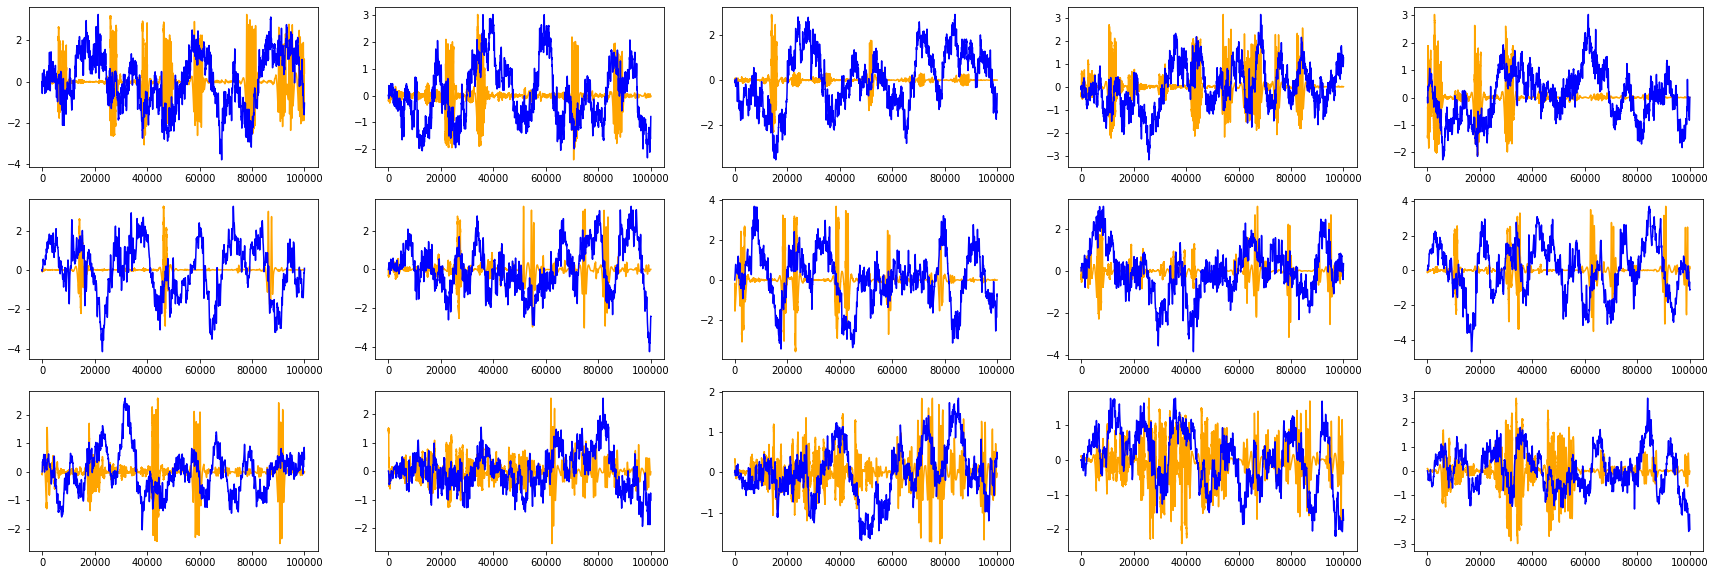

In [ ]:
# with weights
post_processing().visualization(predict_dg, test_fil['train_dg'])

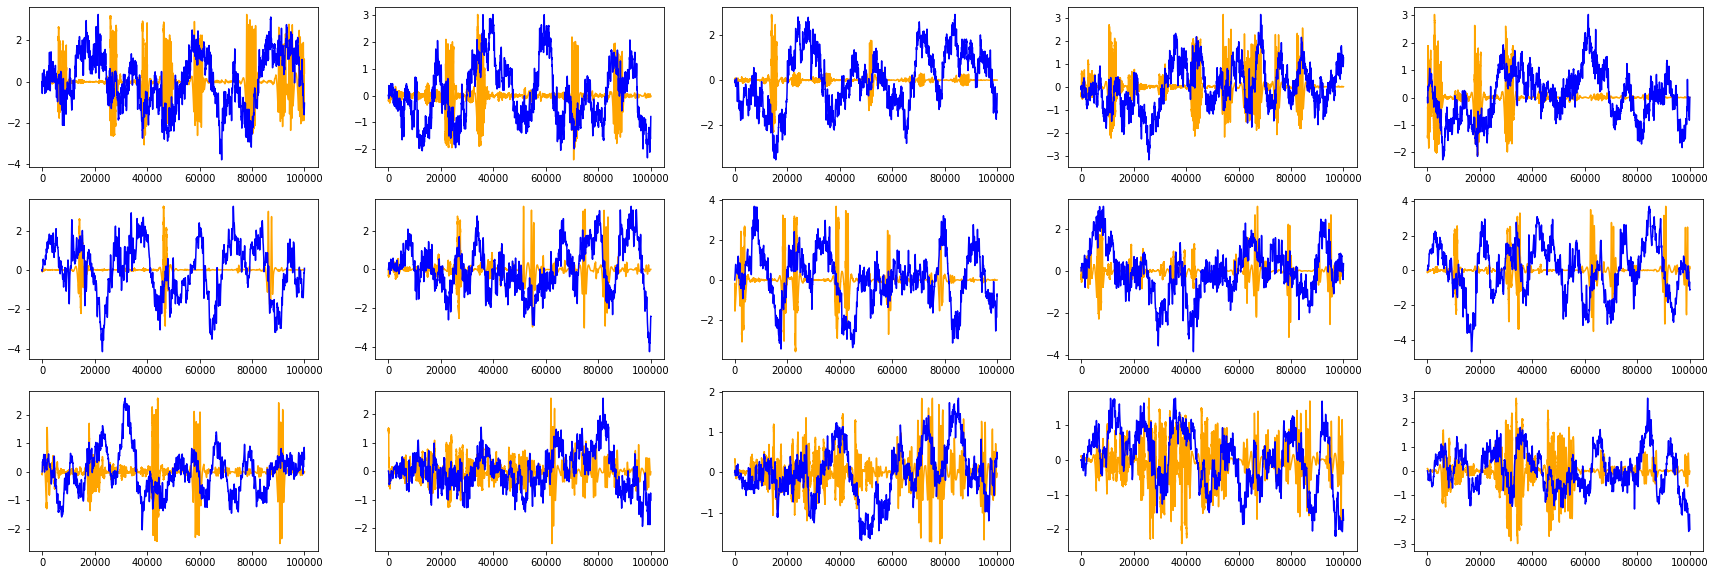

In [ ]:
# weights = 0
post_processing().visualization(predict_dg, test_fil['train_dg'])

In [ ]:
# for channel in range(10):
#   plt.figure(figsize=(30,10))
#   for subj in range(3):
#     for f in range(5):
#       plt.subplot(3,5,5*subj+f+1)
#       plt.plot(test_fil['train_ecog'][0][:,channel] /np.max(test_fil['train_ecog'][0][:,channel]) * np.max(test_fil['train_dg'][subj][:,f]), 'b')
#       plt.plot(test_fil['train_dg'][subj][:,f], color='orange')
#   plt.title('channel' + str(channel))

In [ ]:
OLD = optimal_linear_decoder()
len_leaderboard = len(fil_leaderboard['leaderboard_ecog'][0])
predict_dg_ldb = OLD.OLD_leaderboard(N_wind, fil_training_data, len_leaderboard, feats_training_data, feats_leaderboard, weights, window_length, window_overlap, fs, dir)

subj 0
finger 0
finger 1
finger 2
finger 3
finger 4
subj 1
finger 0
finger 1
finger 2
finger 3
finger 4
subj 2
finger 0
finger 1
finger 2
finger 3
finger 4
done matmul
shape Y_hat 2949


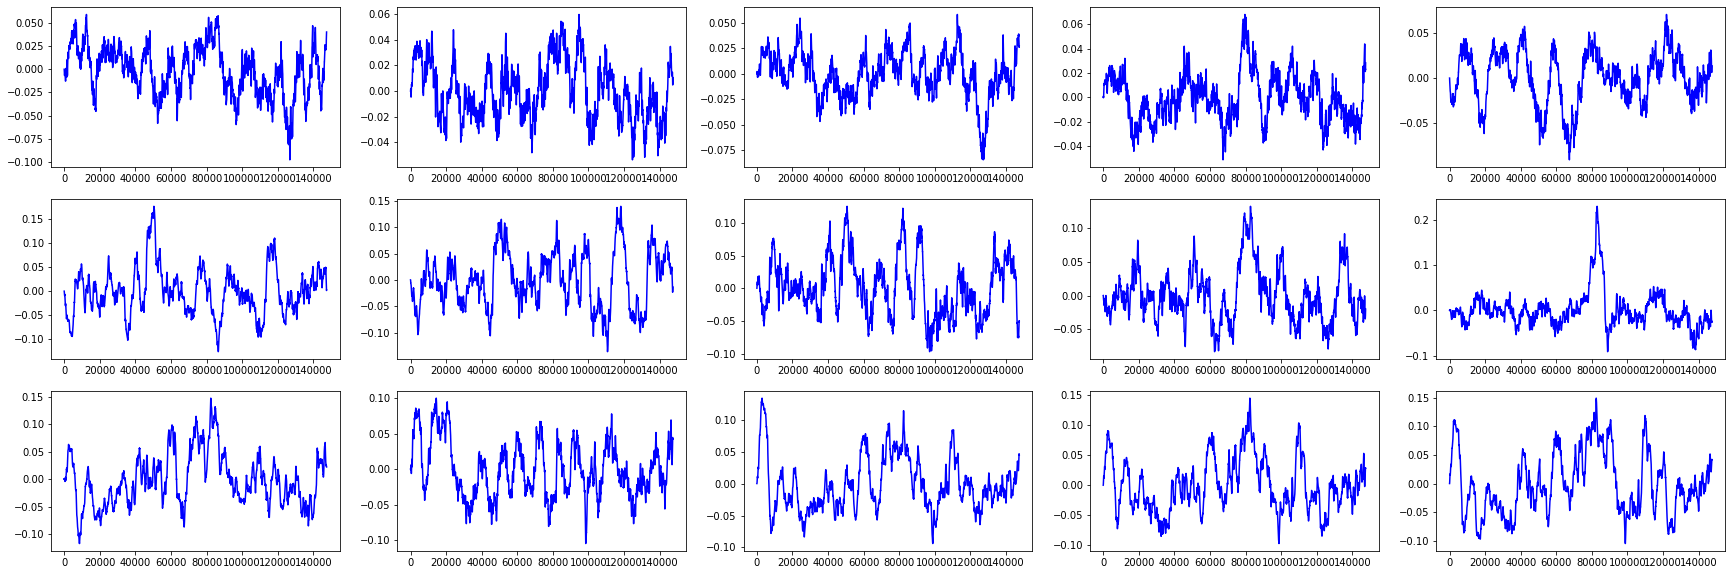

In [ ]:
plt.figure(figsize=(30,10))
for subj in range(3):
  for f in range(5):
    plt.subplot(3,5,5*subj+f+1)
    plt.plot(predict_dg_ldb[subj][:,f] , 'b')

# Rohan Feature Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = '/content/drive/MyDrive/BE_521_final_project'
raw_training_data = loadmat(dir + '/data/raw_training_data.mat')
leaderboard_data = loadmat(dir + '/data/leaderboard_data.mat')

In [ ]:
fs = 1000
window_length = 100e-3 # ms
window_overlap= 50e-3
DP = data_preparation()
fil_training_data = DP.filter_rawdic(raw_training_data)
train_fil, test_fil = DP.split_data(fil_training_data)

In [ ]:
def get_label_data(data):
  # output is 3x3000x5
  #signal=(data["train_dg"][0][:,0]) # define th signal 
  signal=data
  line_avg=np.mean(signal) # compute the mean of the signal
  line_std=np.std(signal) # compute the standard deviation of the signal 

  label_1=np.zeros(len(signal)) #  empty array to save the labels


  for i in range(len(signal)):

      if signal[i] > (line_avg+2*line_std): # if the signal is greater  than 2xstandard deviation + mean 
          label_1[i]=1
  return label_1

In [ ]:
FE = feats_extraction()

In [ ]:
feature_test_data = loadmat(dir+"/feats_train.mat")

In [ ]:
np.shape(feature_test_data["feats_train"][0][0])

(3999, 366)

In [ ]:
#first dimension is key, second dimension is subject, third is [0] always, fourth is appropriate feature 
subjectfeatures = feature_test_data["feats_train"][2][0]

In [ ]:
#store dimensions as variables 
windows, num_features = np.shape(subjectfeatures)
print([windows, num_features])

[3999, 384]


In [ ]:
downsamplefilt = resample(fil_training_data["train_dg"][0], num = windows, axis = 1)
np.shape(downsamplefilt)

In [ ]:
np.shape(fil_training_data["train_dg"])

In [ ]:
downsamplefilt

In [ ]:
#generation of labels 
labels_store=np.zeros([3,5,windows]) # instantiate emptry matrix to store labels
for subject_idx in range(3):
  for finger_idx in range(5):
    labels_store[subject_idx,finger_idx,:]=get_label_data(downsamplefilt[subject_idx][:,finger_idx])

In [ ]:
subj, fingers, data_len = np.shape(labels_store)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
#takes in the labels from get_labels and run channel selection per subject and finger 
def channelselection(labels_store, subject, finger):
  labels_subjfing = labels_store[subject, finger, :]
  subjectfeatures = feature_test_data["feats_train"][subject][0]
  k=10
  kf=KFold(n_splits=k)
  split=kf.split(subjectfeatures)
  index_store = []
  for train_index, test_index in split:
    index_store.append([train_index,test_index])
  svc = LinearSVC(random_state = 10, dual=False)
  num_folds = 10
  store_coefs = []
  for i in range(num_folds):
    Xtrain = subjectfeatures[index_store[i][0], :]
    Xtest = subjectfeatures[index_store[i][1], :]
    Ytrain = labels_subjfing[index_store[i][0]]
    Ytest = labels_subjfing[index_store[i][1]]
    svc.fit(Xtrain, Ytrain) # fit training data
    out = svc.coef_
    store_coefs.append(out)
  mean_coefs = np.mean(store_coefs, axis = 0)
  shaped_coefs = np.reshape(mean_coefs, [-1, 6])
  weights = np.mean(shaped_coefs, axis = 1)
  weights = weights ** 2 
  weights = weights / np.sum(weights)
  return weights #gets the weights that are unshaped, see below for the reshaping 

In [ ]:
store_all_weights = []
for subject in range(3):
  for finger in range(5):
    weights = channelselection(labels_store, subject, finger)
    print(np.shape(weights))
    weights = list(weights)
    store_all_weights.append(weights)

In [ ]:
reshaped_store_weights = np.reshape(store_all_weights, [3, 5]) 

In [ ]:
savemat('weightdata.mat', mdict={'weights': reshaped_store_weights})

# Implementing SVR

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
#takes in the labels from get_labels and run channel selection per subject and finger 
def runSVR(labels_store, subject, finger):
  labels_subjfing = labels_store[subject, finger, :]
  subjectfeatures = feature_test_data["feats_train"][subject][0]
  k=10
  kf=KFold(n_splits=k)
  split=kf.split(subjectfeatures)
  index_store = []
  for train_index, test_index in split:
    index_store.append([train_index,test_index])
  svc = LinearSVR(random_state = 10, dual=False)
  num_folds = 10
  store_coefs = []
  for i in range(num_folds):
    Xtrain = subjectfeatures[index_store[i][0], :]
    Xtest = subjectfeatures[index_store[i][1], :]
    Ytrain = labels_subjfing[index_store[i][0]]
    Ytest = labels_subjfing[index_store[i][1]]
    svc.fit(Xtrain, Ytrain) # fit training data
    out = svc.score(Xtrain, Ytrain)
    store_coefs.append(out)
  return store_coefs #gets the weights that are unshaped, see below for the reshaping 

In [ ]:
store_all_scores = []
for subject in range(3):
  for finger in range(5):
    scores = runSVR(labels_store, subject, finger)
    scores = list(scores)
    store_all_scores.append(scores)